In [1]:
# Import libraries
import os
import re
import pandas as pd
import numpy as np
import seaborn as sms
from datetime import datetime, date, time
from natsort import natsorted
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# Find usable subjects (i.e., non-outliers)
os.listdir('../../istart-mid/derivatives/')
sub_df=pd.read_csv('../../istart-mid/derivatives/OutlierRuns.tsv',sep='\t')

sub_df=sub_df[sub_df['outlier_run']==False]
sub_df['sub_run']=sub_df['Sub']+'_'+sub_df['run'].astype('str')
sub_df.head()

,Sub,task,run,tsnr,fd_mean,outlier_run,sub_run
0,sub-1001,mid,1,69.988391,0.149729,False,sub-1001_1
1,sub-1001,mid,2,55.697644,0.184703,False,sub-1001_2
2,sub-1002,mid,1,77.148079,0.111157,False,sub-1002_1
3,sub-1002,mid,2,90.519196,0.092381,False,sub-1002_2
4,sub-1003,mid,1,66.602654,0.171448,False,sub-1003_1


In [3]:
#Make a list of the files
Mat_Beh_dir='../../istart/Monetary_Incentive/data'
ML_EvFiles_list=natsorted([os.path.join(root,f) for root,dirs,files in os.walk(
    Mat_Beh_dir) for f in files if 'run' in f])
print("The number of Subjects are: %s"%(len([x for x in os.listdir(Mat_Beh_dir) if x.startswith('sub')])))
print("The number of files are: %s"%(len(ML_EvFiles_list)))
print("----------------------------------------")

# Make Conditions for Run1 and Run2
run_cond=loadmat('%s/../timing/run1.mat'%(Mat_Beh_dir))
run1=run_cond['run']['cond'][0,0]
run1 = np.where(run1==['1'], 'Large_gain', run1)
run1 = np.where(run1==[1], 'Large_gain', run1)
run1 = np.where(run1==['2'], 'Large_loss', run1)
run1 = np.where(run1==['3'], 'Small_gain', run1)
run1 = np.where(run1==['4'], 'Small_loss', run1)
run1 = np.where(run1==['5'], 'Neutral', run1)
run1=np.concatenate(run1)

run_cond=loadmat('%s/../timing/run2.mat'%(Mat_Beh_dir))
run2=run_cond['run']['cond'][0,0]
run2 = np.where(run2==[1], 'Large_gain', run2)
run2 = np.where(run2==['1'], 'Large_gain', run2)
run2 = np.where(run2==['2'], 'Large_loss', run2)
run2 = np.where(run2==['3'], 'Small_gain', run2)
run2 = np.where(run2==['4'], 'Small_loss', run2)
run2 = np.where(run2==['5'], 'Neutral', run2)
run2=np.concatenate(run2)

The number of Subjects are: 60
The number of files are: 83
----------------------------------------


/tmp/ipykernel_1906586/1684058216.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  run1 = np.where(run1==['1'], 'Large_gain', run1)
/tmp/ipykernel_1906586/1684058216.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  run1 = np.where(run1==[1], 'Large_gain', run1)


In [4]:
# Print files
display(ML_EvFiles_list)

['../../istart/Monetary_Incentive/data/sub-1001/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1001/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1002/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1002/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1003/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1004/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1004/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1006/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1007/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1007/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1009/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1009/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1010/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1010/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1011/run-1_output.m

In [5]:
# Define dataframe for RTs
data=[]
for ML_EvFile in ML_EvFiles_list:
    #print(ML_EvFile)
    sub='sub-'+re.search('sub-(.*)/',ML_EvFile).group(1)
    run=re.search('run-(.*)_out',ML_EvFile).group(1)
    #if sub+'_'+run in sub_df['sub_run'].values:
    #print(sub,run)
    mat = loadmat(ML_EvFile)  # load mat-file
    mdata = mat['output']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciiencPy reads in structures as structureprintd NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convene make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    # Reconstruct the columns of the data table from just the time series
    # Use the number of intervals to test if a field is a column or metadata
    columns = [n for n in ndata]
    #Check fo frame
    # now make a data frame, setting the time stamps as the index
    lens=[len(x[0]) for x in ndata.values()]
    if lens.count(lens[0]) == len(lens):
        df = pd.DataFrame(np.transpose(np.concatenate([ndata[c] for c in columns])),
                  columns=columns)
        if run=='1':
            if len(df)==50:
                df['trial_type']=run1[0:50]
            elif len(df)==75:
                df['trial_type']=run1
        if run=='2':
            df['trial_type']=run2
        df['sub']=sub
        df['run']=run
        data.append(df)
df=pd.concat(data)

/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='RT', ylabel='Count'>

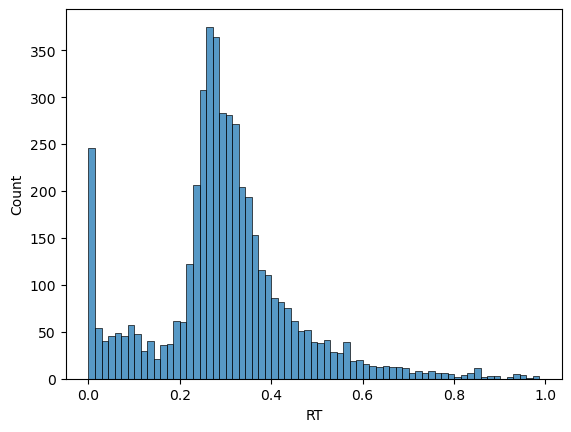

In [6]:
# Plot histogram of RTs
sms.histplot(x=df['RT'])

In [7]:
# Account for missed responses
misses=[]
for sub in df['sub'].unique():
    tmp=df[df['sub']==sub]
    for run in tmp['run'].unique():
        tmp=tmp[tmp['run']==run]
        misses.append(len(tmp[(tmp['RT']==0)&(tmp['outcome']==0)]))
print(" The largest number of missed trials is %s this is less than 20 percent of trials"%(np.max(misses)))

 The largest number of missed trials is 6 this is less than 20 percent of trials


In [8]:
# Sort by trial type
df.loc[df["trial_type"] == "1", "trial_type"] = "Large_gain"
df['run']=df['run'].astype(int)
df.groupby(by=['sub','run']).max().reset_index()

,sub,run,outcome,trial_starts,target_starts,RT,thresh,trial_type
0,sub-1001,1,1.0,443.596841,445.607023,0.690546,0.584389,Small_loss
1,sub-1001,2,1.0,450.916843,454.927744,0.846985,0.511823,Small_loss
2,sub-1002,1,1.0,443.595531,445.605782,0.491392,0.464767,Small_loss
3,sub-1002,2,1.0,450.928644,454.939221,0.571258,0.466639,Small_loss
4,sub-1003,1,1.0,443.546470,445.555652,0.738533,0.496835,Small_loss
...,...,...,...,...,...,...,...,...
75,sub-3210,1,1.0,679.768941,682.773112,0.823762,0.458219,Small_loss
76,sub-3212,1,1.0,679.607846,682.610161,0.857764,0.456245,Small_loss
77,sub-3218,1,1.0,679.653301,682.655712,0.557942,0.466697,Small_loss
78,sub-3220,1,1.0,679.645557,682.648115,0.922452,0.596440,Small_loss


In [9]:
# Remove misses
no_miss=df[(df['RT']>0.01)]
no_miss[no_miss['RT']==0]
df=no_miss

/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: xlabel='RT', ylabel='Count'>

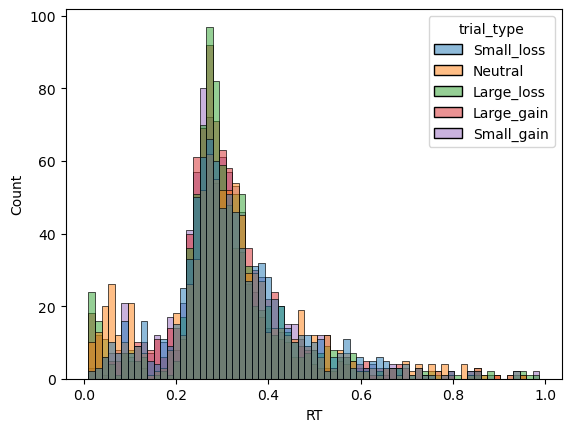

In [10]:
# Plot histogram of RTs by trial type
sms.histplot(x=df['RT'],hue=df['trial_type'])

In [11]:
# Give numeric labels to trial types
df.loc[df["trial_type"] == "1", "trial_type"] = "Large_gain"

df['Trial_code']=df['trial_type'].map({"Large_loss":-2,"Small_loss":-1,"Neutral":0,"Small_gain":1,"Large_gain":2})
df['Trial_code'].unique()

array([-1,  0, -2,  2,  1])

In [12]:
# Check labels for an individual sub
df[df['sub']=='sub-3199']

,outcome,trial_starts,target_starts,RT,thresh,trial_type,sub,run,Trial_code
0,1.0,4.005512,6.007814,0.317093,0.354215,Small_loss,sub-3199,1,-1
1,1.0,10.013537,12.015883,0.208390,0.359615,Neutral,sub-3199,1,0
2,1.0,20.824335,24.826691,0.347995,0.405430,Large_loss,sub-3199,1,-2
3,0.0,30.432088,33.435449,0.476594,0.469060,Large_loss,sub-3199,1,-2
4,0.0,38.880598,42.884209,0.412769,0.433266,Large_gain,sub-3199,1,2
...,...,...,...,...,...,...,...,...,...
70,0.0,639.997196,643.999625,0.329608,0.338173,Small_gain,sub-3199,1,1
71,0.0,656.809263,658.811312,0.436908,0.383256,Small_gain,sub-3199,1,1
72,1.0,664.016155,667.018345,0.042789,0.324323,Small_loss,sub-3199,1,-1
73,1.0,670.022225,674.024309,0.380891,0.478732,Small_gain,sub-3199,1,1


,sub,trial_type,outcome,trial_starts,target_starts,RT,thresh,run,Trial_code
0,sub-1001,Large_gain,1.0,246.980226,249.991329,0.305435,0.418198,1.5,2.0
1,sub-1001,Large_loss,1.0,185.605540,188.116553,0.308371,0.411154,1.5,-2.0
2,sub-1001,Neutral,1.0,207.873973,209.884223,0.332187,0.443540,1.5,0.0
3,sub-1001,Small_gain,1.0,281.873566,285.883902,0.320507,0.376292,1.5,1.0
4,sub-1001,Small_loss,1.0,154.275646,158.286305,0.367956,0.413490,1.0,-1.0


/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


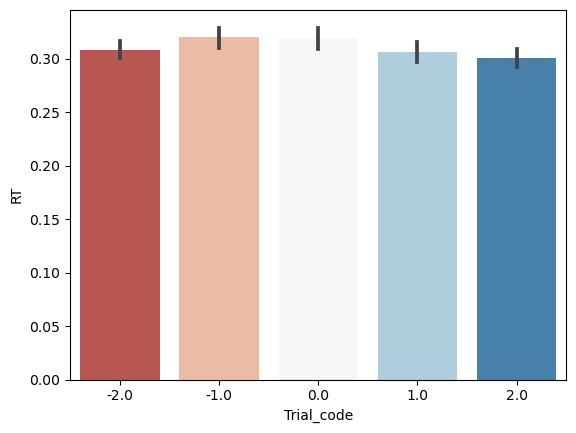

In [13]:
# Plot avg. RT across all subs; would be nice to run this for individual subs
df['run']=df['run'].astype(int)
group_df=df.groupby(by=['sub','trial_type']).median()
group_df=group_df.reset_index()
display(group_df.head())
#display(group_df)
g=sms.barplot(x='Trial_code',y='RT',data=group_df,errorbar=('ci',68),palette='RdBu')
#plt.savefig('figures/RT_BAR.svg')
plt.show()

/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ZPOOL/data/tools/anaconda/tun46412/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


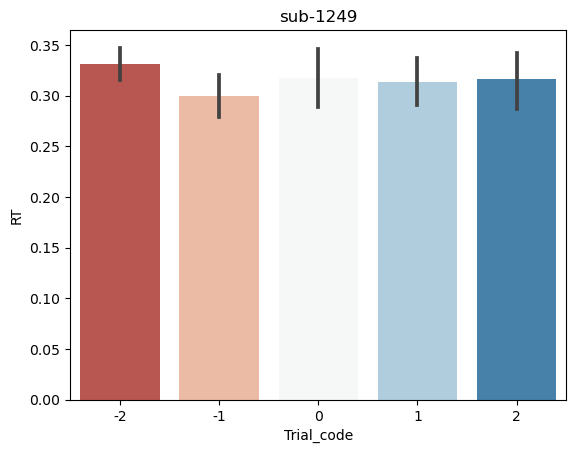

In [14]:
# Plot avg. RT for individual subs
# sub-1016, 1247, 1249 all low VBeta
# sub-3206 great high VBeta
sub_df = df[df['sub']=='sub-1249']

g=sms.barplot(x='Trial_code',y='RT',errorbar=('ci',68),data=sub_df,palette='RdBu')
#g.set_title(str(sub_df['sub']))
sub_df
title=sub_df['sub'].iloc[1]
g.set_title(str(title))
##plt.savefig('figures/RT_BAR.svg')
plt.show()

In [15]:
# Is mean RT different for LG>N?
from scipy.stats import ttest_rel
print("Is the Mean RT difference between large and Neutral significant?")
ttest_rel(group_df[group_df['trial_type']=='Large_gain']['RT'],
         group_df[group_df['trial_type']=='Neutral']['RT'])

Is the Mean RT difference between large and Neutral significant?


TtestResult(statistic=-2.203953423148404, pvalue=0.03165524096557052, df=56)

In [16]:
# Is mean RT different for LL>SL?
print("Is the Mean RT difference between large and small losses significant")

ttest_rel(group_df[group_df['trial_type']=='Large_loss']['RT'],
         group_df[group_df['trial_type']=='Neutral']['RT'])

Is the Mean RT difference between large and small losses significant


TtestResult(statistic=-1.2357526896496092, pvalue=0.2217093315588961, df=56)

In [17]:
# Determine VBeta (i.e., how well does data fit inverted V for RTs?) for each sub
data=[]
#polynomial fit with degree = 2
for sub in group_df['sub'].unique():
    tmp=group_df[group_df['sub']==sub]
    LG_RT=tmp[tmp['trial_type']=="Large_gain"]['RT'].values[0]
    LL_RT=tmp[tmp['trial_type']=="Large_loss"]['RT'].values[0]
    Neu_RT=tmp[tmp['trial_type']=="Neutral"]['RT'].values[0]
    model = np.poly1d(np.polyfit(tmp['Trial_code'].values, tmp['RT'].values, 2))
    
    data.append([sub,model[2],
                 LG_RT-Neu_RT,
                 LL_RT-Neu_RT,
                 (LG_RT-Neu_RT)-(LL_RT-Neu_RT)
                ])
Fits=pd.DataFrame(columns=['Sub','V_beta','LG-N','LL-N',"rel_rew"],data=data)
Fits.to_csv('../derivatives/Fits_of_RT.csv',index=False)

In [18]:
# Print Fits
Fits.head()

,Sub,V_beta,LG-N,LL-N,rel_rew
0,sub-1001,-0.008945,-0.026752,-0.023816,-0.002937
1,sub-1002,-0.013022,-0.072843,-0.063259,-0.009585
2,sub-1003,0.000093,0.054024,-0.009556,0.063580
3,sub-1004,-0.002456,0.020756,-0.019793,0.040550
4,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405


In [19]:
# Read individual diff measures
#per_df=pd.read_excel('MID participant tracker_ 1.xlsx',sheet_name='model 4E basemodel 5')
per_df=pd.read_excel('MID-tracker_model-5.xlsx')
per_df['Subject']='sub-'+per_df['Subject'].astype('str')
per_df.head()

,Subject,Ones,tsnr_demean,fd_mean_demean,comp-RS,comp-RSsq_demean,comp-SU,RSxSU_demean,SUxRSsq_demean,VBeta_demean,VBetaxRS_demean,VBetaxRSsq_demean
0,sub-1001,1,-0.427375,0.048571,0.469388,-8.028738,0.491868,-0.329042,-0.630447,-0.003551,-0.003695,0.017792
1,sub-1003,1,-0.162367,0.124435,0.469388,-8.028738,0.006384,-0.556922,3.267372,0.004369,0.000023,-0.045797
2,sub-1004,1,-0.124384,-0.456402,2.469388,-2.151187,-0.284906,-1.263462,3.931514,0.002530,0.004219,-0.016160
3,sub-1006,1,1.312499,-0.852311,-0.530612,-7.967514,-1.158776,0.054942,12.551192,-0.000310,-0.001863,-0.008246
4,sub-1009,1,1.190812,0.054972,1.469388,-6.089963,-1.158776,-2.262610,10.375531,0.003308,0.002832,-0.030862


In [20]:
# Add Fits to df with other indiv diff measures
total_df=pd.merge(Fits, per_df, how='left', left_on=['Sub'], right_on=['Subject'])
total_df.head()
# This is printing a bunch of NaNs, I think bc we've tampered with the MID participant tracker _ 1.xlsx file from the previous kernel

,Sub,V_beta,LG-N,LL-N,rel_rew,Subject,Ones,tsnr_demean,fd_mean_demean,comp-RS,comp-RSsq_demean,comp-SU,RSxSU_demean,SUxRSsq_demean,VBeta_demean,VBetaxRS_demean,VBetaxRSsq_demean
0,sub-1001,-0.008945,-0.026752,-0.023816,-0.002937,sub-1001,1.0,-0.427375,0.048571,0.469388,-8.028738,0.491868,-0.329042,-0.630447,-0.003551,-0.003695,0.017792
1,sub-1002,-0.013022,-0.072843,-0.063259,-0.009585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-1003,0.000093,0.054024,-0.009556,0.063580,sub-1003,1.0,-0.162367,0.124435,0.469388,-8.028738,0.006384,-0.556922,3.267372,0.004369,0.000023,-0.045797
3,sub-1004,-0.002456,0.020756,-0.019793,0.040550,sub-1004,1.0,-0.124384,-0.456402,2.469388,-2.151187,-0.284906,-1.263462,3.931514,0.002530,0.004219,-0.016160
4,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405,sub-1006,1.0,1.312499,-0.852311,-0.530612,-7.967514,-1.158776,0.054942,12.551192,-0.000310,-0.001863,-0.008246


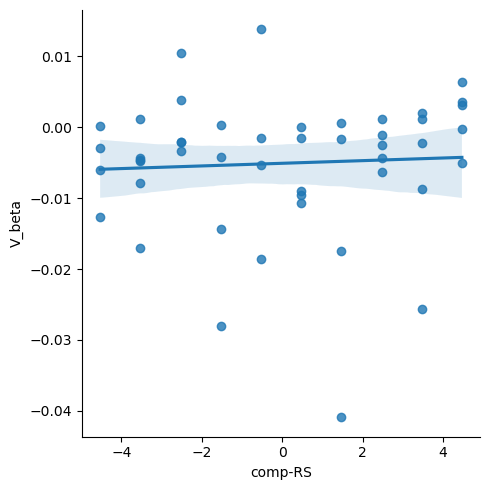

r:  0.056836116963242166 p: 0.7043437296348307


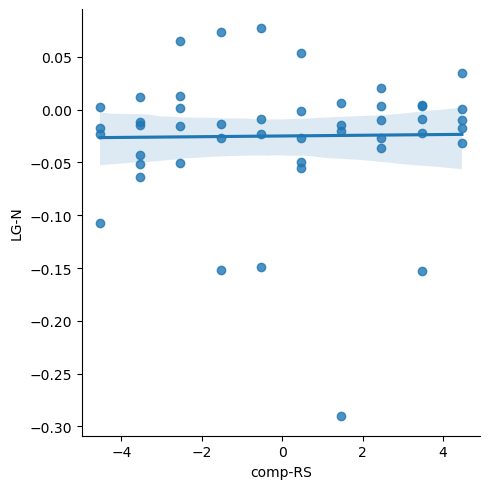

r:  0.016104884957488276 p: 0.9144372631465691


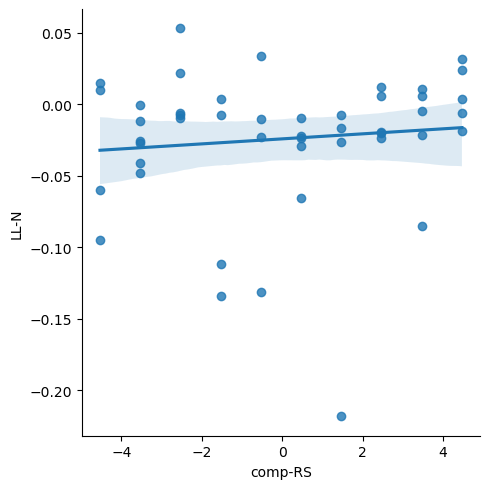

r:  0.105801024291264 p: 0.479073135960413


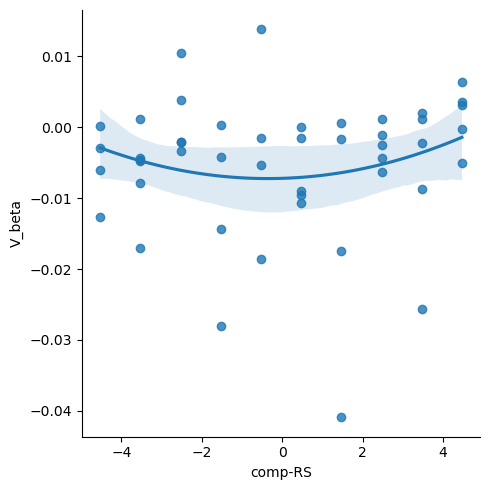

r:  0.18575782350355652 p: 0.2112581318567758


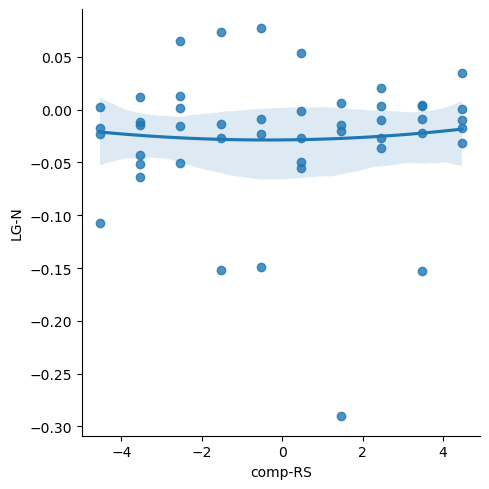

r:  0.0504033621973609 p: 0.736526104137356


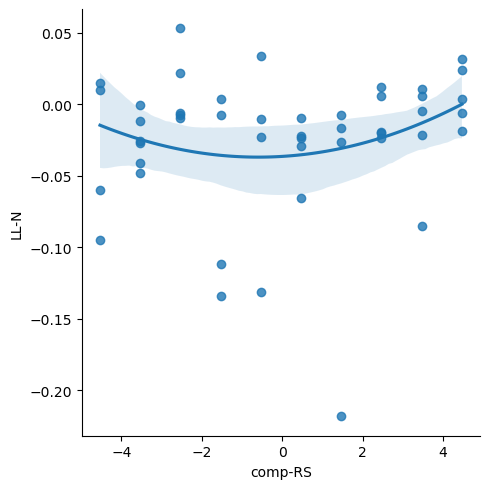

r:  0.21255058947842748 p: 0.15146269535586931


In [21]:
# Generate scatterplots: VBeta & other contrasts by Composite Reward (i.e., Reward Sensitivity)
from scipy.stats import pearsonr,kendalltau
responses=['V_beta','LG-N','LL-N']#'rel_rew']

total_df=total_df[~total_df['comp-RS'].isna()]

for resp in responses:
    sms.lmplot(x='comp-RS',y=resp,data=total_df,order=1)
    plt.show()
    r,p=pearsonr(total_df['comp-RS'],total_df[resp])
    print('r:  %s p: %s'%(r,p))
for resp in responses:
    sms.lmplot(x='comp-RS',y=resp,data=total_df,order=2)
    plt.show()
    r,p=pearsonr(total_df['comp-RSsq_demean'],total_df[resp])
    print('r:  %s p: %s'%(r,p))

In [22]:
# Add TEPS data to total_df
#teps_data = pd.read_excel("/ZPOOL/data/projects/istart-mid-clean/code/ISTART-ALL-Combined-042122_MID-subs.xlsx")
#teps_df = teps_data[['ID', 'score_teps_ant', 'score_teps_con', 'teps_ant_split', 'teps_con_split']]
#total_df['score_teps_ant'] = teps_df['score_teps_ant']

#teps_df
total_df

,Sub,V_beta,LG-N,LL-N,rel_rew,Subject,Ones,tsnr_demean,fd_mean_demean,comp-RS,comp-RSsq_demean,comp-SU,RSxSU_demean,SUxRSsq_demean,VBeta_demean,VBetaxRS_demean,VBetaxRSsq_demean
0,sub-1001,-0.008945,-0.026752,-0.023816,-0.002937,sub-1001,1.0,-0.427375,0.048571,0.469388,-8.028738,0.491868,-0.329042,-0.630447,-0.003551,-0.003695,0.017792
2,sub-1003,0.000093,0.054024,-0.009556,0.063580,sub-1003,1.0,-0.162367,0.124435,0.469388,-8.028738,0.006384,-0.556922,3.267372,0.004369,0.000023,-0.045797
3,sub-1004,-0.002456,0.020756,-0.019793,0.040550,sub-1004,1.0,-0.124384,-0.456402,2.469388,-2.151187,-0.284906,-1.263462,3.931514,0.002530,0.004219,-0.016160
4,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405,sub-1006,1.0,1.312499,-0.852311,-0.530612,-7.967514,-1.158776,0.054942,12.551192,-0.000310,-0.001863,-0.008246
6,sub-1009,-0.001678,-0.014629,-0.007453,-0.007177,sub-1009,1.0,1.190812,0.054972,1.469388,-6.089963,-1.158776,-2.262610,10.375531,0.003308,0.002832,-0.030862
7,sub-1010,-0.004171,-0.014044,0.004005,-0.018049,sub-1010,1.0,-0.527877,0.074305,-1.530612,-5.906289,3.266075,-5.559013,-15.971753,0.000684,-0.003075,-0.014758
8,sub-1011,-0.006342,-0.036053,-0.023506,-0.012547,sub-1011,1.0,-0.096909,0.514406,2.469388,-2.151187,-1.450066,-4.140694,6.437992,-0.002235,-0.007547,-0.005911
9,sub-1012,-0.006064,-0.022781,-0.059955,0.037174,sub-1012,1.0,1.903314,-1.047657,-4.530612,12.277384,-1.450066,6.009768,-14.484389,-0.001055,0.002753,-0.023675
10,sub-1013,-0.005111,-0.017062,-0.018792,0.001730,sub-1013,1.0,1.659803,-1.298713,4.469388,11.726364,-0.802755,-4.147741,-6.094766,-0.000125,-0.002587,-0.012186
11,sub-1015,-0.007821,-0.011908,-0.011626,-0.000282,sub-1015,1.0,0.760258,0.233755,-3.530612,4.216160,2.336704,-8.809915,13.170548,-0.002835,0.007980,-0.022670


In [ ]:
# Generate scatterplots: VBeta x TEPS 
sms.lmplot(x='score_teps_ant',y='V_beta',data=total_df)
plt.show()
r,p=pearsonr(total_df['comp-RS'],total_df['V_beta'])
print('r:  %s p: %s'%(r,p))

# VBeta x RS
sms.lmplot(x='comp-RS',y='V_beta',data=total_df)
plt.show()
r,p=pearsonr(total_df['comp-RS'],total_df['V_beta'])
print('r:  %s p: %s'%(r,p))

# VBeta X RS x TEPS